# DoWhy for CATE
Source: https://www.pywhy.org/dowhy/v0.5.1/example_notebooks/dowhy-conditional-treatment-effects.html

In [ ]:
!pip install dowhy
!pip install gcastle
!pip install econml
!pip install shap

# 1. Generate Synthetic Data

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [ ]:
np.random.seed(0)

In [23]:
data = dowhy.datasets.linear_dataset(
    BETA,
    num_common_causes=4,
    num_samples=10000,
    num_instruments=2,
    num_effect_modifiers=2,
    num_treatments=1,
    treatment_is_binary=False,
    num_discrete_common_causes=2,
    num_discrete_effect_modifiers=0,
    one_hot_encode=False
    )
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.618286  0.342595  0.0  0.973156 -0.394872  0.788341  0  1  12.805378   
1 -0.312205  0.203183  0.0  0.617418 -1.060182 -1.057089  2  2   7.651853   
2  1.107187  0.311965  0.0  0.721246 -0.707163  0.779320  2  0  18.678066   
3  0.450523  0.822142  0.0  0.983421 -0.339521  0.205199  0  3  13.447860   
4  0.382970  0.345056  0.0  0.364488  0.688778 -1.179594  2  3  12.087997   

            y  
0  162.324310  
1   80.731553  
2  226.887522  
3  181.948011  
4  147.604479  
True causal estimate is 12.19106891984308


# 2. Causal Model

In [24]:
print(data["gml_graph"])

graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "y"] node[ id "X1" label "X1"] edge[ source "X1" target "y"]]


In [25]:
model = CausalModel(
  data=data["df"],
  treatment=data["treatment_name"],
  outcome=data["outcome_name"],
  graph=data["gml_graph"]
)

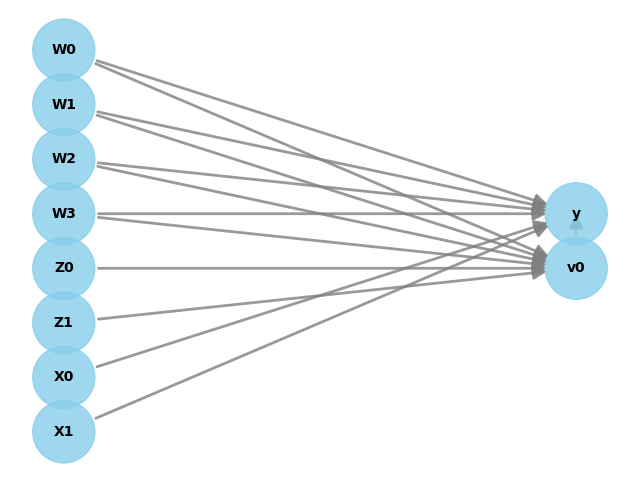

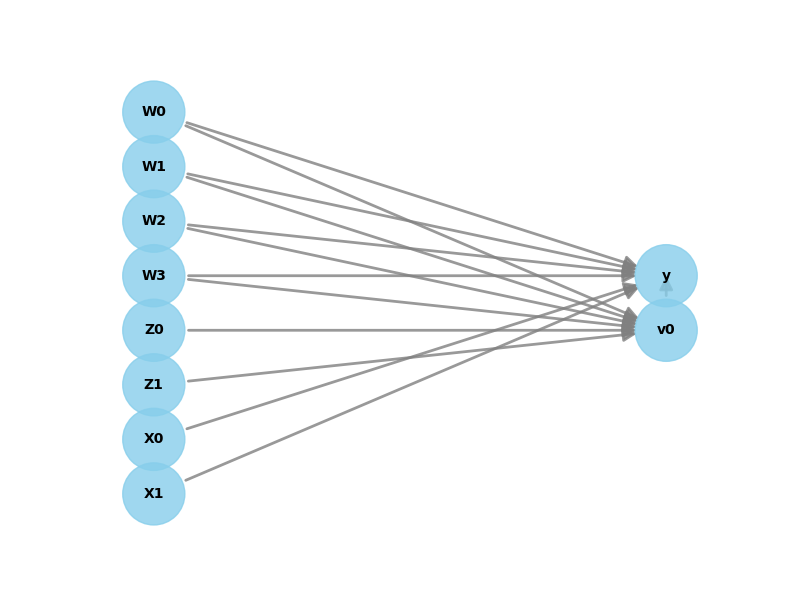

In [26]:
from IPython.display import Image, display

model.view_model()
display(Image(filename="causal_model.png"))

# 3. Identify Causal Effect

In [27]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# 4. Baseline - Linear Model

In [28]:
# Using DoWhy
linear_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1
    )
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3+v0*X1+v0*X0
Target units: 

## Estimate
Mean value: 12.19110110020758
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.356, -0.312]   (-3.576, -0.115]      6.758437
                   (-0.115, 0.474]       7.360516
                   (0.474, 0.97]         7.582662
                   (0.97, 1.563]         8.202597
                   (1.563, 4.679]        8.777645
(-0.312, 0.278]    (-3.576, -0.115]      9.526752
                   (-0.115, 0.474]      10.118967
                   (0.474, 0.97]        10.468131
                   (0.97, 1.563]        10.910190
                   (1.563, 4.679]     

In [29]:
# Using Statsmodels
import statsmodels.api as sm

list_features = [x for x in list(df.columns) if x != data["outcome_name"]]
print(list_features)

Y = df[data["outcome_name"]]
X = df[list_features]
X = sm.add_constant(X)
model_lm = sm.OLS(Y,X)
results = model_lm.fit()

['X0', 'X1', 'Z0', 'Z1', 'W0', 'W1', 'W2', 'W3', 'v0']


In [30]:
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 1.878e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:28:50   Log-Likelihood:                -47702.
No. Observations:               10000   AIC:                         9.542e+04
Df Residuals:                    9990   BIC:                         9.550e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5833      0.864    -20.361      0.000     -19.276     -15.890
X0             6.0895      0.286     21.284      0.000       5.529       6.650
X1            26.1330      0.284     91.918      0.000      25.576      26.690
Z0            -1.4651      3.677     -0.398      0.690      -8.673       5.743
Z1            -1.4834      3.375     -0.439      0.660      -8.100       5.133
W0             4.1238      1.165      3.541      0.000       1.841       6.407
W1             5.5430      1.327      4.176      0.000       2.941       8.145
W2             2.6062      1.310      1.989      0.047       0.038       5.174
W3             2.9105      0.297      9.789      0.000       2.328       3.493
v0            12.2775      0.287     42.730      0.000      11.714      12.841
==============================================================================
Omnibus:                     1098.211   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9785.392
Skew:                           0.119   Prob(JB):                         0.00
Kurtosis:                       7.840   Cond. No.                         225.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Params
print(results.params)
print()
print(results.params[data["treatment_name"]])

const   -17.583267
X0        6.089477
X1       26.133042
Z0       -1.465065
Z1       -1.483435
W0        4.123847
W1        5.543046
W2        2.606160
W3        2.910480
v0       12.277522
dtype: float64

v0    12.277522
dtype: float64


# 5. DML

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    target_units = lambda df: df["X0"]>1,  # condition used for CATE
    confidence_intervals=False,
    method_params={"init_params":{
        'model_y':GradientBoostingRegressor(),
        'model_t': GradientBoostingRegressor(),
        "model_final":LassoCV(fit_intercept=False),
        'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                   "fit_params":{}
                   })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 12.809813483739923
Effect estimates: [[12.19593103]
 [11.69714234]
 [14.00091306]
 ...
 [12.8113496 ]
 [19.27756905]
 [14.32067163]]



In [36]:
# Getting the estimate (alternative)
estimate = model.estimate_effect(
    identified_estimand=identified_estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False)
        },
        'fit_params':{}
    }
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 12.091552404895664
Effect estimates: [[12.16553677]
 [10.22089162]
 [11.67169162]
 ...
 [13.58286665]
 [ 7.22535025]
 [16.90880952]]



In [38]:
dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    target_units = 1,  # condition used for CATE
    confidence_intervals=False,
    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                  'model_t': GradientBoostingRegressor(),
                                  "model_final":LassoCV(fit_intercept=False),
                                  'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                    "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X1,X0
Target units: 

## Estimate
Mean value: 12.120341892554002
Effect estimates: [[12.23103026]
 [10.21165896]
 [11.71734754]
 ...
 [13.59685722]
 [ 7.27124541]
 [16.93581643]]



In [37]:
print("True causal estimate is", data["ate"])

True causal estimate is 12.19106891984308


In [39]:
# Confidence intervals
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    target_units = "ate",
    confidence_intervals=True,
    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                  'model_t': GradientBoostingRegressor(),
                                  "model_final": LassoCV(fit_intercept=False),
                                  'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                   "fit_params":{
                       'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                       }
                    }
    )
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W1,W2,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W2,W3,U) = P(y|v0,W0,W1,W2,W3)

## Realized estimand
b: y~v0+W0+W1+W2+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 12.177328611001908
Effect estimates: [[12.27497091]
 [10.27978491]
 [11.76773833]
 ...
 [13.66111812]
 [ 7.31566338]
 [16.99981976]]
95.0% confidence interval: [[[12.33552426 10.22428814 11.82118649 ... 13.77291278  7.06697537
   17.18401634]]

 [[12.54635784 10.46187384 11.98932879 ... 13.98729405  7.40775988
   17.53682791]]]



In [43]:
df[data["treatment_name"]].head()

,v0
0,12.805378
1,7.651853
2,18.678066
3,13.447860
4,12.087997


In [44]:
# New inferences
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
display(test_df.head(5))
print()

dml_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    target_units = test_df,
    confidence_intervals=False,
    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                  'model_t': GradientBoostingRegressor(),
                                  "model_final":LassoCV(),
                                  'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                    "fit_params":{}
                    }
    )
print(dml_estimate.cate_estimates)

,X0,X1
0,0.517514,0.355694
1,0.136091,0.341405
2,0.660447,0.303711
3,0.314925,0.633128
4,0.829761,0.530470



[[11.39177891]
 [11.05496618]
 [11.32840086]
 [12.15536142]
 [12.20675329]
 [12.12962305]
 [11.78257816]
 [11.68988442]
 [11.92737511]
 [10.15611576]]


# 6. Tests

In [45]:
from IPython.display import clear_output

In [46]:
# Random
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")

clear_output()
print(res_random)

Refute: Add a random common cause
Estimated effect:11.582283714779328
New effect:11.578831776217587
p value:0.88



In [47]:
# Adding an unobserved common cause variable
res_unobserved=model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.01,
    effect_strength_on_outcome=0.02
    )

clear_output()
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:11.582283714779328
New effect:11.547836944776211



In [48]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
    num_simulations=10 # at least 100 is good, setting to 10 for speed
    )

clear_output()
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:11.582283714779328
New effect:0.006873226413449016
p value:0.409300020936471



In [49]:
# Removing a random subset of the data
res_subset=model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8,
    num_simulations=10
    )

clear_output()
print(res_subset)

Refute: Use a subset of data
Estimated effect:11.582283714779328
New effect:11.601029575488974
p value:0.2589942808376531

